In [35]:
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import torch

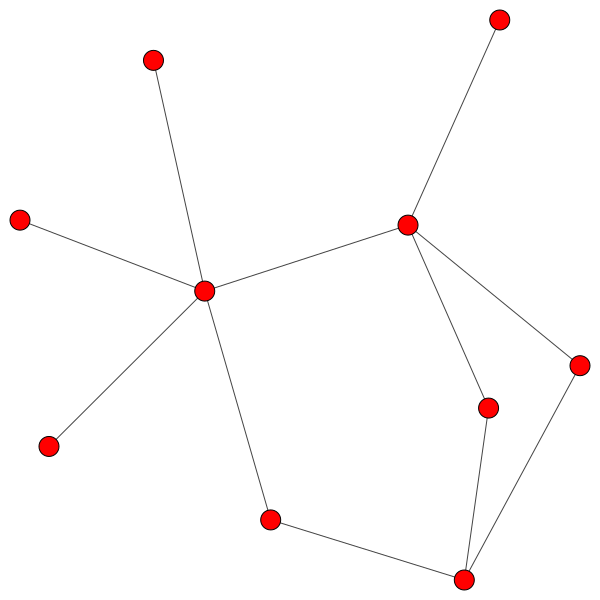

In [47]:
g = ig.Graph.Erdos_Renyi(n = 10, m = 11)
layout = g.layout('kk')
ig.plot(g, layout = layout)

In [48]:
adjM = torch.autograd.Variable(torch.Tensor(g.get_adjacency().data), requires_grad = True)
N = adjM.shape[0]

# get Laplacian
L = torch.diag(torch.matmul(adjM, torch.ones(N))) - adjM
L_mod = L + torch.ones_like(L)/N

# calculate log dets
eps = 10e-6
print(-torch.logdet(L_mod))
print(-torch.logdet(L_mod + eps * torch.eye(N)))

tensor(-5.0752, grad_fn=<NegBackward>)
tensor(-5.0753, grad_fn=<NegBackward>)


In [40]:
torch.det(L_mod)

tensor(159.9999, grad_fn=<DetBackward>)

# Implement on our dataset

In [26]:
import os
if "ntbk" in os.getcwd():
    os.chdir("..")
print(os.getcwd())

import sys
sys.path.append(os.path.join(os.getcwd(), "otgnn"))


%load_ext autoreload
%autoreload 2

from otgnn.models import GCN
from otgnn.graph import MolGraph
from otgnn.utils import save_model, load_model
from otgnn.graph import SYMBOLS, FORMAL_CHARGES, BOND_TYPES, get_bt_index

from mol_opt.mol_opt import MolOpt
from mol_opt.data_mol_opt import MolOptDataset
from mol_opt.data_mol_opt import get_loader
from mol_opt.decoder_mol_opt import MolOptDecoder
from mol_opt.arguments import get_args
from mol_opt.train_mol_opt import main, get_latest_model
from mol_opt.ot_utils import encode_target, FGW
from mol_opt.train_mol_opt import ft
from mol_opt.ot_utils import Penalty as PenaltyOld

from rdkit.Chem import MolFromSmiles

from molgen.metrics.Penalty import Penalty as PenaltyNew

import torch
from torch import nn
import numpy as np
import time

/home/octav/gitrepos/tum-thesis
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
data_loader = get_loader("iclr19-graph2graph/data/qed", "val", 96, False)
for i in data_loader:
    X = (MolGraph(i[0]))
    Y = (MolGraph(i[1]))
    break

In [8]:
sys.argv = ["", "-cuda"]
args = get_args()
args.output_dir = "mol_opt/output/"

mol_opt = MolOpt(args)
mol_opt_decoder = MolOptDecoder(args)
loss = FGW(alpha = 0.5)

In [9]:
x_embedding, x_delta_hat = mol_opt.forward(X)
yhat_embedding = x_embedding + x_delta_hat
yhat_logits = mol_opt_decoder.forward(yhat_embedding, Y)
yhat_labels = mol_opt_decoder.discretize(*yhat_logits)

pred_pack = (yhat_labels, yhat_logits, Y.scope), Y
loss(*pred_pack).item() / 96

3.452212333679199

In [49]:
loss(*pred_pack)

/home/octav/gitrepos/tum-thesis/otgnn/models/gromov_modules.py:394: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  nce_reg = torch.nn.LogSoftmax()(torch.stack(all_nce_dists))[0]


tensor(331.4124, device='cuda:0', grad_fn=<AddBackward0>)

In [51]:
pen.BOND_TYPES

[rdkit.Chem.rdchem.BondType.SINGLE,
 rdkit.Chem.rdchem.BondType.DOUBLE,
 rdkit.Chem.rdchem.BondType.TRIPLE,
 rdkit.Chem.rdchem.BondType.AROMATIC,
 None]

In [10]:
symbols_logits, charges_logits, bonds_logits = yhat_logits

In [11]:
bonds_logits.shape

torch.Size([44494, 5])

In [68]:
pen = PenaltyNew(ft, connectivity=True, prev_epoch = 5, annealing_rate = 0.04)
pen(*pred_pack, 0)

(tensor(-104.4341, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(0., device='cuda:0'))

In [70]:
pen.tau

0.7737809374999998

In [34]:
pen2 = PenaltyOld()
pen2(*pred_pack) * 0.015

tensor(-81.9809, device='cuda:0', grad_fn=<MulBackward0>)

In [210]:
bond_idx = 0
num_atoms = 22
adjM = bonds_soft[bond_idx:bond_idx+num_atoms*num_atoms].view(num_atoms, num_atoms, -1)

In [211]:
1 - adjM[:,:,-1]

tensor([[0.8456, 0.8452, 0.8513, 0.8494, 0.8474, 0.8477, 0.8517, 0.8507, 0.8534,
         0.8487, 0.8479, 0.8479, 0.8479, 0.8484, 0.8507, 0.8486, 0.8499, 0.8449,
         0.8535, 0.8545, 0.8514, 0.8570],
        [0.8452, 0.8500, 0.8541, 0.8484, 0.8484, 0.8462, 0.8506, 0.8503, 0.8588,
         0.8520, 0.8492, 0.8473, 0.8493, 0.8472, 0.8495, 0.8491, 0.8523, 0.8452,
         0.8541, 0.8573, 0.8517, 0.8555],
        [0.8513, 0.8541, 0.8572, 0.8545, 0.8529, 0.8517, 0.8579, 0.8553, 0.8613,
         0.8546, 0.8544, 0.8513, 0.8533, 0.8527, 0.8574, 0.8526, 0.8555, 0.8512,
         0.8588, 0.8625, 0.8588, 0.8620],
        [0.8494, 0.8484, 0.8545, 0.8485, 0.8509, 0.8497, 0.8536, 0.8531, 0.8593,
         0.8508, 0.8504, 0.8498, 0.8521, 0.8513, 0.8547, 0.8492, 0.8545, 0.8490,
         0.8564, 0.8561, 0.8548, 0.8589],
        [0.8474, 0.8484, 0.8529, 0.8509, 0.8474, 0.8483, 0.8549, 0.8507, 0.8597,
         0.8518, 0.8517, 0.8475, 0.8511, 0.8495, 0.8507, 0.8487, 0.8548, 0.8486,
         0.8539, 0.858

In [212]:
adjM[0,1,:]

tensor([0.2219, 0.2304, 0.2179, 0.1751, 0.1548], device='cuda:0',
       grad_fn=<SliceBackward>)

In [213]:
adjM.shape

torch.Size([22, 22, 5])

In [200]:
bonds_soft.shape

torch.Size([44494, 5])

In [199]:
bonds_logits[1,:]

tensor([ 0.1878,  0.2254,  0.1696, -0.0491, -0.1718], device='cuda:0',
       grad_fn=<SliceBackward>)

In [191]:
bonds_soft[:,-1]

tensor([0.1544, 0.1548, 0.1487,  ..., 0.1446, 0.1421, 0.1404], device='cuda:0',
       grad_fn=<SelectBackward>)

In [228]:
bonds_soft = 1-nn.functional.gumbel_softmax(logits = adjM, hard = True, dim = 2)[:,:,-1]

In [230]:
adjM.shape

torch.Size([22, 22, 5])

In [232]:
bonds_soft

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
         1., 1., 0., 0.],
        [1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
         0., 1., 1., 1.],
        [1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
         1., 1., 1., 1.],
        [0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1.,
         0., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
         1., 1., 0., 1.],
        [0., 1., 1., 1., 1., 1., 1., 